# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to predict whether a given cherry leaf is healthy or infected.

* Augment images
* Save class indices
* Create model
* Fit model
* Evaluate model

## Inputs

* inputs/mildew-dataset/cherry-leaves/train
* inputs/mildew-dataset/cherry-leaves/test
* inputs/mildew-dataset/cherry-leaves/validation
* image shape embeddings

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments | Insights | Conclusions

---

# Import Libraries

In [122]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Directories

  ## Set Working Directory

In [123]:
# Parent directory
parent_dir =  "/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector"

# Change working directory to parent directory
os.chdir(parent_dir)
print (f"New working directory: {os.getcwd()} ")

New working directory: /Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector 


## Set Input Directory

In [124]:
dataset_dir = "inputs/mildew-dataset/cherry-leaves"
train_dir = os.path.join(parent_dir, dataset_dir, "train")
validation_dir = os.path.join(parent_dir, dataset_dir, "validation")
test_dir = os.path.join(parent_dir, dataset_dir, "test")

## Set Output Directory

In [125]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(parent_dir) and version in os.listdir(parent_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


In [126]:
file_path

'outputs/v1'

---

## Set Labels

In [127]:
# Set the labels
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

In [128]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

### Bar plot - Label Distribution per Dataset Split

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




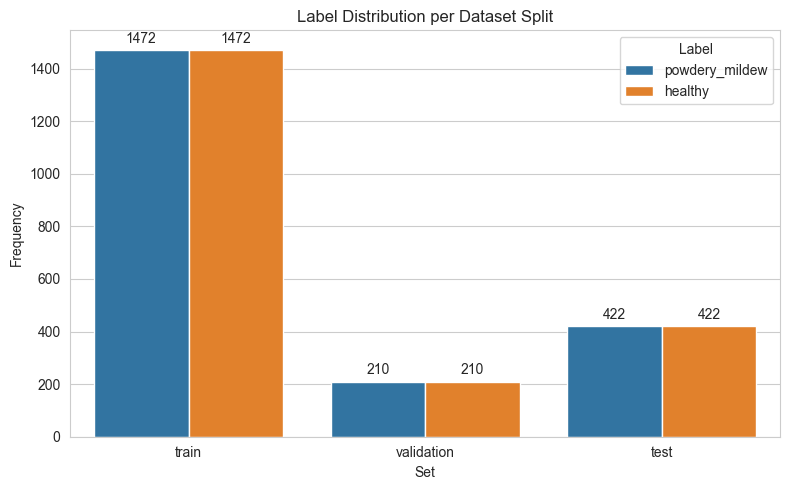

In [129]:
# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(dataset_dir + '/' + folder + '/' + label)))
        }
        for key, value in row.items():
            data[key].append(value)
        print(f"* {folder} - {label}: {row['Frequency']} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Assign the plot to ax
ax = sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)

plt.title("Label Distribution per Dataset Split")
plt.tight_layout()
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


### Pie Chart - Dataset Split Distribution

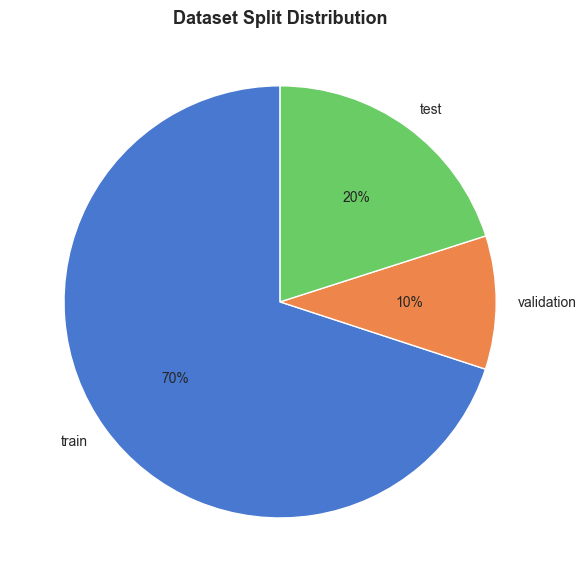

In [130]:
# Aggregate totals for each dataset split
split_totals = (
    df_freq.groupby('Set', as_index=False)['Frequency']
           .sum()
           .sort_values('Set', key=lambda s: s.map({'train':0,'validation':1,'test':2}))
)

# Calculate percentages
summary = split_totals.rename(columns={'Frequency': 'Images'})
summary['Percentage'] = (summary['Images'] / summary['Images'].sum() * 100).round(0)

# Prepare labels and values
set_labels = summary['Set'].tolist()
sizes = summary['Images'].tolist()

# Palette:
colors = sns.color_palette("muted", n_colors=len(set_labels))

# Label format: show % only
def autopct_pct_only(pct):
    return f"{pct:.0f}%"

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=set_labels,
    autopct=autopct_pct_only,
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Dataset Split Distribution", fontsize=13, weight='bold')
plt.tight_layout()

# Save and show
plt.savefig(f"{file_path}/split_distribution_pie.png", bbox_inches='tight', dpi=150)
plt.show()


---

# Image Data Augmentation

### Image Data Generator

In [131]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [132]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


### Set Batch Size

In [133]:
batch_size = 20  # Set batch size

### Augment training image dataset

In [134]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_dir,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [135]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [136]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


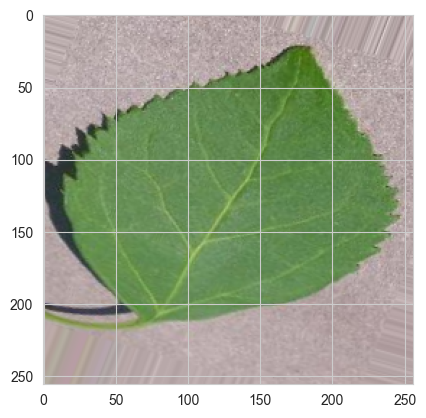

(20, 256, 256, 3)


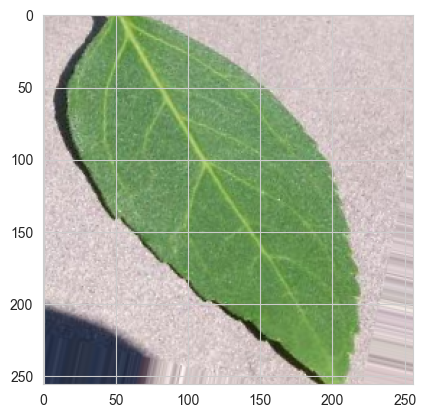

(20, 256, 256, 3)


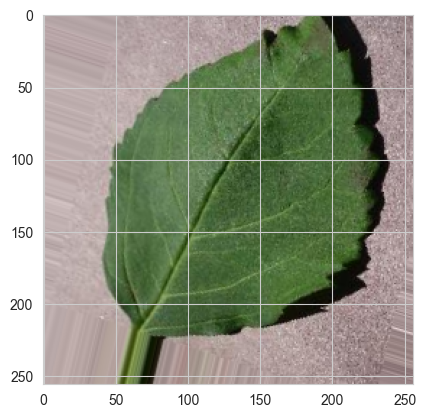

In [137]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation images

(20, 256, 256, 3)


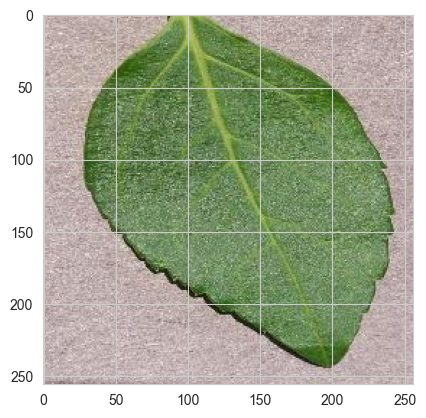

(20, 256, 256, 3)


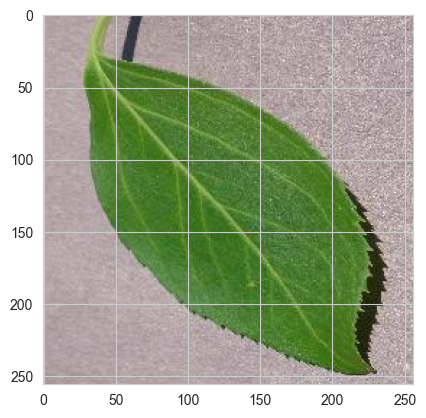

(20, 256, 256, 3)


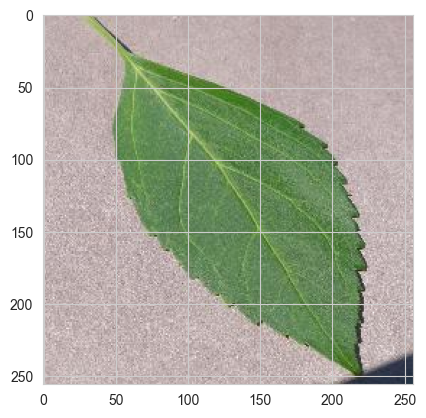

In [138]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented test images

(20, 256, 256, 3)


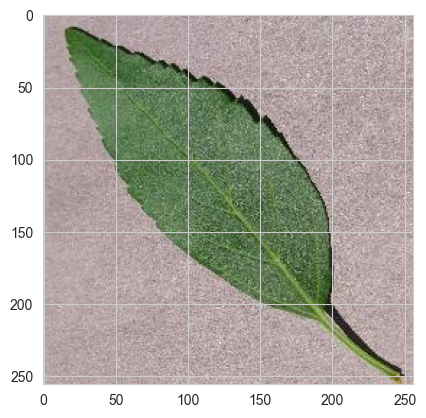

(20, 256, 256, 3)


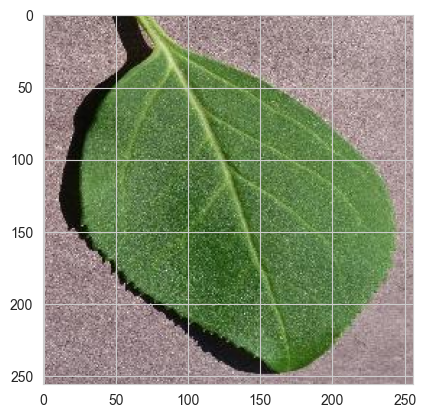

(20, 256, 256, 3)


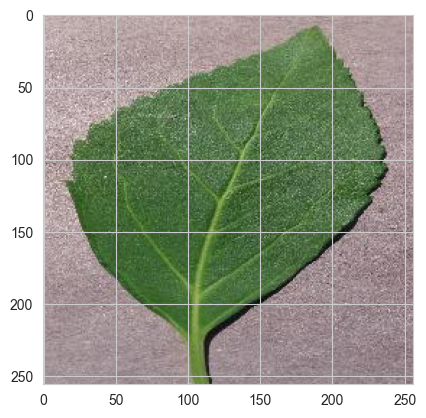

In [139]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [140]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

## ML Model

### Import Model Packages

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Model

In [142]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Model Summary

In [143]:
create_tf_model().summary()

/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

### Early Stopping

In [144]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit Model for Model Training

In [145]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.8567 - loss: 0.3298 - val_accuracy: 0.9500 - val_loss: 0.5469
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9500 - loss: 0.6068

/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.6068 - val_accuracy: 0.9762 - val_loss: 0.0797
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.9850 - loss: 0.0540 - val_accuracy: 0.9976 - val_loss: 0.0046
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9870 - loss: 0.0402 - val_accuracy: 0.9857 - val_loss: 0.0469
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.6504e-04 - val_accuracy: 0.9905 - val_loss: 0.0228


### Save Model

In [146]:
model.save(f"{file_path}/mildew_detector_model_{version}.h5")

---

# Model Performance

## Model learning curve

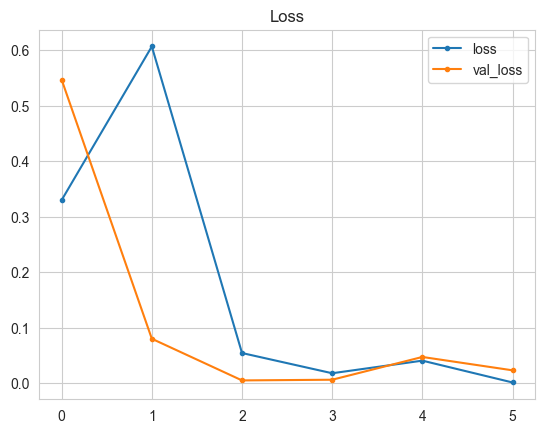

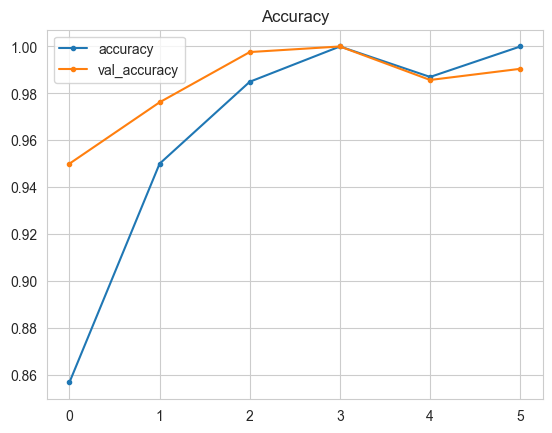

In [147]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

### Load saved model

In [148]:
from keras.models import load_model
model = load_model(f"{file_path}/mildew_detector_model_{version}.h5")

### Evaluate Model on Test Set

In [149]:
evaluation = model.evaluate(test_set)


/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9953 - loss: 0.0327


### Save Evaluation Pickle

In [150]:
joblib.dump(value=evaluation,
            filename=f"{file_path}/evaluation{version}.pkl")


['outputs/v1/evaluationv1.pkl']

## Predict on New Data

### Load Random Image as PIL

powdery_mildew
Image shape: (256, 256), Image mode: RGB


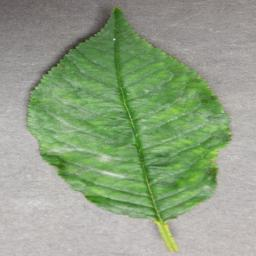

In [151]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] # 'healthy' or 'powdery_mildew'

print(label)

img_path = os.path.join(test_dir, label, os.listdir(os.path.join(test_dir, label))[pointer])
pil_image = image.load_img(img_path, target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


### Convert Image to Array and Prepare for Prediction

In [152]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict Class Probabilities

In [153]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.97704405
powdery_mildew
